### Neurophysiology and Biophysics - Practical course WS 2024/25
__Cornelia Kopp-Scheinpflug & Kay Thurley__

# Miniproject: Gap junctions and network synchorization

In this notebook we simulate a small network of electrically coupled Drosophila motoneurons. The network shows different regimes of synchrony depending on the coupling strength of the GAP junctions, which is supposed to underly the insect's flight. The model was used in Hürkey et al. (2023) and adapted by Kay Thurley (2024).


_Requirements:_ You will need Python 3 and the packages Numpy, Matplotlib and BRIAN2.


We start by importing the relevant packages.

#### This notebook is specifically for trying different splay states

In [19]:
import numpy as np
from brian2 import *
import sys, os
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import json

from utils.brianutils import units
from utils.random_initial_conditions import *
from utils.sim import *

from collections import defaultdict

def extract_splay_sequences(spike_ids, spike_times, N=5, ignore_id=4):
    """
    Extract repeating splay sequences, ignoring spikes from a given neuron ID.

    Parameters
    ----------
    spike_ids : array-like
        Neuron IDs for each spike event (e.g., SpM.i)
    spike_times : array-like
        Corresponding spike times (e.g., SpM.t)
    N : int
        Total neuron count (used for pattern length)
    ignore_id : int
        Neuron ID to ignore (e.g., 4)

    Returns
    -------
    pattern_times : dict
        {pattern_string: [list of start times]}
    """

    # Filter out ignored neuron spikes
    valid_mask = spike_ids != ignore_id
    spike_ids = spike_ids[valid_mask]
    spike_times = spike_times[valid_mask]

    pattern_times = defaultdict(list)

    # find indices where neuron 0 spikes
    zero_spike_indices = np.where(spike_ids == 0)[0]

    # each pattern is now N-1 neurons long
    pattern_len = N - 1

    for idx in zero_spike_indices:
        if idx + pattern_len <= len(spike_ids):
            pattern = ''.join(str(x) for x in spike_ids[idx:idx + pattern_len])
            t = spike_times[idx]  # start time
            pattern_times[pattern].append(t)

    return pattern_times


Then we define load some parameters and define the neuron.

In [20]:
md_SNL = json.load(open("cfg/Berger_SNL.json"))
md_SNIC = json.load(open("cfg/Berger_SNIC.json"))
ggap_hom = np.load('cfg/ggap_hom.npy')*nS
ggap_het = np.load('cfg/ggap_het.npy')*nS

In [21]:
# noise free simulations
# ## case1: weak SNL
# used for figure 3B
N = 5
num_runs = 10
g_gap = ggap_hom
# g_gap = .15*nS
dur = 5*second
solver = 'heun'#'rk4'
dt = 100*us
# noise 5e-8 is too high 
# noise 1e-8 it low enough to get 2 states
# noise 2e-8 gives 10 states!

# try noise levels between 
noise_stdev = 1.7e-8
fname='SNL_weakcoupling_nonoise'

# φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
# initial_values = pick_initial_phase_SNL(φs_chosen)


patterns_combined = {}

for _ in range(num_runs):  # e.g., num_runs = 10
    initial_values = random_initial_phase_SNL(5)
    StM1, SpM1 = run_sim(
        N, md_SNL, g_gap, None,
        initial_values=initial_values,
        dur=dur, σnoise=noise_stdev,
        solver=solver, dt=dt
    )

    patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

    # Combine with the main dictionary
    for pattern, times in patterns.items():
        if pattern not in patterns_combined:
            patterns_combined[pattern] = list(times)
        else:
            patterns_combined[pattern].extend(times)


Starting simulation at t=0. s for a duration of 5. s
3.7271 s (74%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 13s
Starting simulation at t=0. s for a duration of 5. s
4.0526 s (81%) simulated in 10s, estimated 2s remaining.
5. s (100%) simulated in 12s
Starting simulation at t=0. s for a duration of 5. s
3.8381 s (76%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 13s
Starting simulation at t=0. s for a duration of 5. s
3.5128 s (70%) simulated in 10s, estimated 4s remaining.
5. s (100%) simulated in 14s
Starting simulation at t=0. s for a duration of 5. s
3.4857 s (69%) simulated in 10s, estimated 4s remaining.
5. s (100%) simulated in 14s
Starting simulation at t=0. s for a duration of 5. s
3.8727 s (77%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 12s
Starting simulation at t=0. s for a duration of 5. s
3.8383 s (76%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 12s
Starting simulation at t=0.

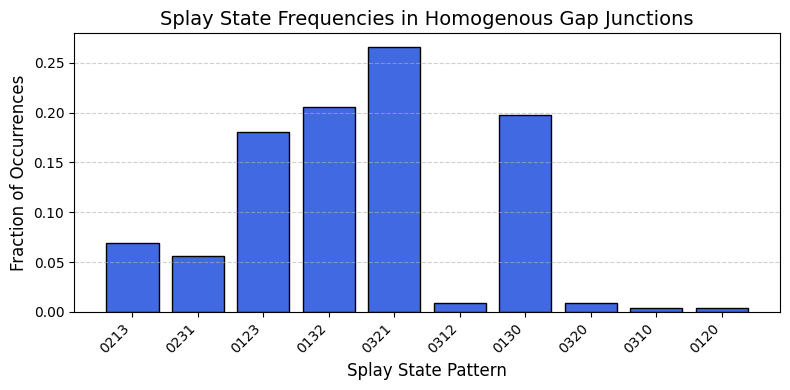

In [22]:

pattern_names = list(patterns_combined.keys())
occurrences = np.array([len(times) for times in patterns_combined.values()])

# Normalize to fractions (sum = 1)
fractions = occurrences / occurrences.sum()

# Sort patterns by descending frequency
sorted_indices = np.argsort(fractions)[::-1]
pattern_names = [pattern_names[i] for i in sorted_indices]
fractions = fractions[sorted_indices]
# Normalize to fractions (sum = 1)
fractions = occurrences / occurrences.sum()
if g_gap is ggap_hom:
    title = 'Homogeneous Gap Junctions'
else:
    title = 'Heterogeneous Gap Junctions'

plt.figure(figsize=(8, 4))
plt.bar(pattern_names, fractions, color='royalblue', edgecolor='black')
plt.xlabel('Splay State Pattern', fontsize=12)
plt.ylabel('Fraction of Occurrences', fontsize=12)
plt.title(f'Splay State Frequencies in Homogenous Gap Junctions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
# noise free simulations
# ## case1: weak SNL
# used for figure 3B
N = 5
num_runs = 10
g_gap = ggap_het
# g_gap = .15*nS
dur = 5*second
solver = 'heun'#'rk4'
dt = 100*us
# noise 5e-8 is too high 
# noise 1e-8 it low enough to get 2 states
# noise 2e-8 gives 10 states!

# try noise levels between 
noise_stdev = 1.7e-8
fname='SNL_weakcoupling_nonoise'

# φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
# initial_values = pick_initial_phase_SNL(φs_chosen)


patterns_combined = {}

for _ in range(num_runs):  # e.g., num_runs = 10
    initial_values = random_initial_phase_SNL(5)
    StM1, SpM1 = run_sim(
        N, md_SNL, g_gap, None,
        initial_values=initial_values,
        dur=dur, σnoise=noise_stdev,
        solver=solver, dt=dt
    )

    patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

    # Combine with the main dictionary
    for pattern, times in patterns.items():
        if pattern not in patterns_combined:
            patterns_combined[pattern] = list(times)
        else:
            patterns_combined[pattern].extend(times)


Starting simulation at t=0. s for a duration of 5. s
3.744 s (74%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 13s
Starting simulation at t=0. s for a duration of 5. s
3.9113 s (78%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 12s
Starting simulation at t=0. s for a duration of 5. s
3.695 s (73%) simulated in 10s, estimated 4s remaining.
5. s (100%) simulated in 13s
Starting simulation at t=0. s for a duration of 5. s
3.4455 s (68%) simulated in 10s, estimated 5s remaining.
5. s (100%) simulated in 14s
Starting simulation at t=0. s for a duration of 5. s
3.7746 s (75%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 13s
Starting simulation at t=0. s for a duration of 5. s
3.8406 s (76%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 12s
Starting simulation at t=0. s for a duration of 5. s
3.8279 s (76%) simulated in 10s, estimated 3s remaining.
5. s (100%) simulated in 13s
Starting simulation at t=0. s

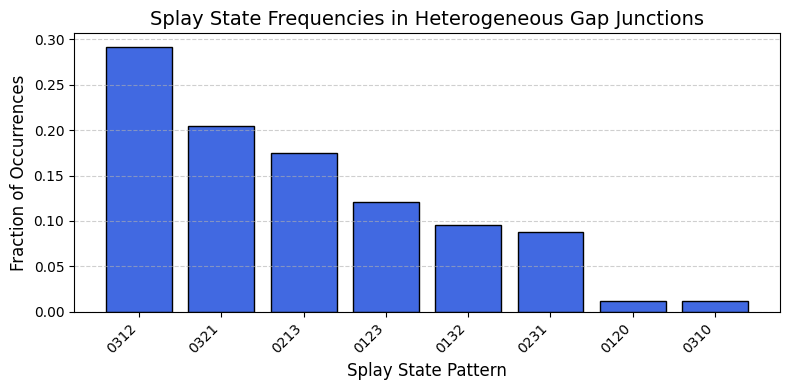

In [24]:
pattern_names = list(patterns_combined.keys())
occurrences = np.array([len(times) for times in patterns_combined.values()])

# Normalize to fractions (sum = 1)
fractions = occurrences / occurrences.sum()

# Sort patterns by descending frequency
sorted_indices = np.argsort(fractions)[::-1]
pattern_names = [pattern_names[i] for i in sorted_indices]
fractions = fractions[sorted_indices]
if g_gap is ggap_hom:
    title = 'Homogeneous Gap Junctions'
else:
    title = 'Heterogeneous Gap Junctions'

plt.figure(figsize=(8, 4)) 
plt.bar(pattern_names, fractions, color='royalblue', edgecolor='black')
plt.xlabel('Splay State Pattern', fontsize=12)
plt.ylabel('Fraction of Occurrences', fontsize=12)
plt.title(f'Splay State Frequencies in {title}', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Text(0.97, 0.184, '[mV]')

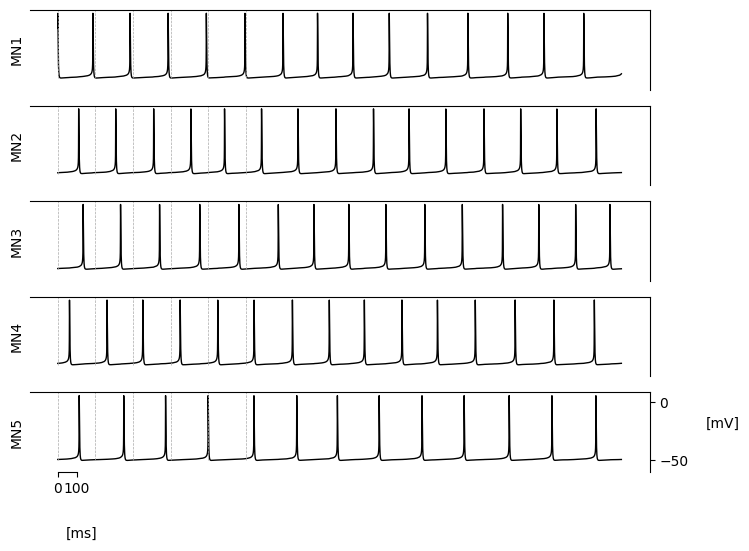

In [25]:
fig, ax = plt.subplots(5, 1, figsize=(8, 6))

ts=StM1.t_
per=np.median(np.diff(SpM1.t_[SpM1.i==0]))*second
t_unit=ms
N=5

tstart = SpM1.t_[SpM1.i==0][SpM1.t_[SpM1.i==0]>2].min()
m=(ts>tstart) & (ts<tstart+10)
for i in range(N):
    ax[i].plot(StM1.t[m]/ms-tstart*1000, StM1.v[i][m]/mV, c='k',lw=1)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_ylabel('MN{}'.format(i+1))
    ax[i].set_yticks([])
    ax[i].set_ylim(-60,)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].set_xticks([])
    # shift = 2000
    # ax[i].set_xlim(0 + shift,300 + shift)

    for k in range(0,6):
        ax[i].plot([k*per/t_unit,k*per/t_unit],[-50,10],'--',lw=0.5,c='darkgrey')


ax[-1].set_xticks([0,100])
ax[-1].spines['bottom'].set_bounds(0,100)
ax[-1].spines['bottom'].set_visible(True)
fig.text(0.17,0.0,'[ms]')

ax[-1].spines['right'].set_visible(True)
ax[-1].yaxis.tick_right()
ax[-1].set_yticks([-50,0])
fig.text(0.97,0.184,'[mV]')

In [26]:
# Coupling coefficient
from utils.convert_ggap_ccs import *
print(ggap2cc(g_gap))

[[-1.51188730e-15  9.94035397e-03  4.41793510e-03  4.41793510e-03
   3.14263213e-03]
 [ 9.94035397e-03 -1.51188730e-15  4.41793510e-03  4.41793510e-03
   3.14263213e-03]
 [ 4.41793510e-03  4.41793510e-03 -1.51188730e-15  9.94035397e-03
   3.14263213e-03]
 [ 4.41793510e-03  4.41793510e-03  9.94035397e-03 -1.51188730e-15
   3.14263213e-03]
 [ 3.14263213e-03  3.14263213e-03  3.14263213e-03  3.14263213e-03
  -1.51188730e-15]]


0.11479999999999999 4.802099999999999
46873


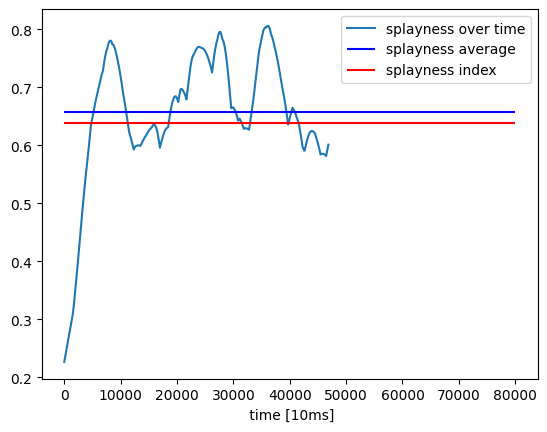

In [27]:
from utils.spiketime_analysis_helper import *
# Splayness index
# Make sure tstart tend and dt have same units 
tmin, tmax = get_tminmax(SpM1)
print(tmin, tmax)
print(len(get_splayness(SpM1, tmin, tmax, 100e-6)[0]))
plt.plot(get_splayness(SpM1, tmin, tmax, 100e-6)[0], label ='splayness over time')
plt.hlines(np.mean(get_splayness(SpM1, tmin, tmax, 100e-6)[0]),0, 80000, color='b', label = 'splayness average')
plt.hlines(get_splayness(SpM1, tmin, tmax, 100e-6)[1],0, 80000, color='r', label = 'splayness index')
plt.xlabel(' time [10ms]')
plt.legend()
plt.show()

In [28]:
patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

for p, times in patterns.items():
    print(f"Pattern {p} occurred {len(times)} times at times {np.round(times,3)}")


Pattern 0312 occurred 25 times at times [0.077 0.281 0.477 0.676 0.88  1.07  1.263 1.466 1.661 1.853 2.042 2.226
 2.421 2.621 2.822 3.024 3.224 3.405 3.591 3.781 3.982 4.194 4.403 4.593
 4.802]


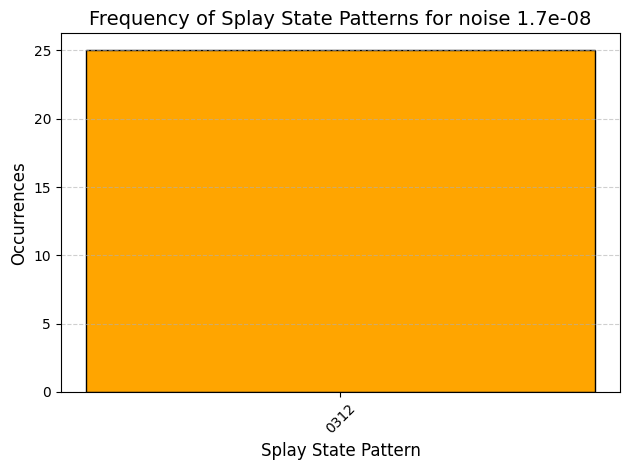

In [29]:
# Assuming you've already run:
# patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

# Extract data for plotting
pattern_names = list(patterns.keys())
occurrences = [len(times) for times in patterns.values()]

# # Sort by most frequent pattern (optional, for clarity)
# sorted_idx = np.argsort(occurrences)[::-1]
# pattern_names = [pattern_names[i] for i in sorted_idx]
# occurrences = [occurrences[i] for i in sorted_idx]

# Plot
plt.figure()
plt.bar(pattern_names, occurrences, color='orange', edgecolor='black', width=0.3)
plt.xlabel('Splay State Pattern', fontsize=12)
plt.ylabel('Occurrences', fontsize=12)
plt.title(f'Frequency of Splay State Patterns for noise {noise_stdev}', fontsize=14)
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [30]:
SpM1.i

<spikemonitor_1.i: array([0, 3, 4, 1, 2, 0, 3, 1, 2, 4, 0, 3, 1, 2, 4, 0, 3, 1, 2, 4, 0, 3,
       1, 2, 4, 0, 3, 1, 2, 4, 0, 3, 1, 2, 0, 4, 3, 1, 2, 0, 4, 3, 1, 2,
       0, 3, 4, 1, 2, 0, 3, 1, 4, 2, 0, 3, 1, 2, 4, 0, 3, 1, 2, 4, 0, 3,
       1, 2, 0, 4, 3, 1, 2, 0, 4, 3, 1, 2, 0, 3, 4, 1, 2, 0, 3, 1, 4, 2,
       0, 3, 1, 4, 2, 0, 3, 1, 4, 2, 0, 3, 1, 2, 4, 0, 3, 1, 2, 0, 4, 3,
       1, 2, 0, 4, 3, 1, 2, 0, 3, 4, 1, 2])>

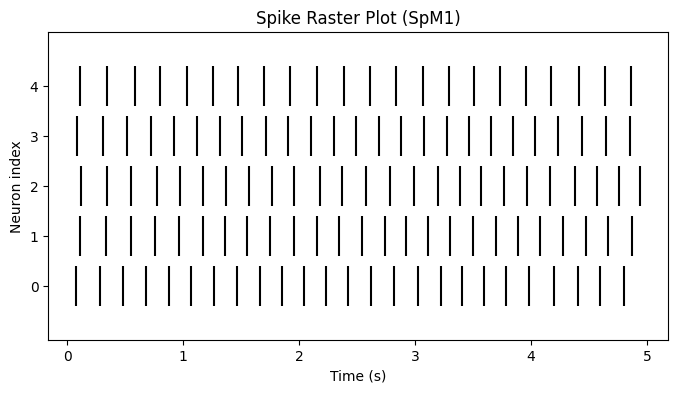

In [31]:
# Extract spike times and indices
spike_times = SpM1.t / second   # convert to float seconds
spike_indices = SpM1.i

# Number of neurons (assuming indices start at 0)
n_neurons = int(max(spike_indices)) + 1

# Collect spikes per neuron
spike_trains = [spike_times[spike_indices == i] for i in range(n_neurons)]

# Plot raster
plt.figure(figsize=(8, 4))
plt.eventplot(spike_trains, colors='black', linelengths=0.8)

plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.title("Spike Raster Plot (SpM1)")
plt.yticks(range(n_neurons))
plt.show()


In [32]:
raise

RuntimeError: No active exception to reraise

In [ ]:
# ### Splayness vs coupling coefficient
# cc_array = [0.001, 0.1, 0.2, 0.3]
# spm_array = []
# for cc in cc_array:
#     g_gap_now = cc2ggap(cc)
#     N = 5
#     g_gap = g_gap_now
#     # g_gap = .15*nS
#     dur = 5*second
#     solver = 'rk4'
#     dt = 100*us

#     fname='SNL_weakcoupling_nonoise'

#     φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
#     initial_values = pick_initial_phase_SNL(φs_chosen)
#     StM1, SpM1 = run_sim(N, md_SNL, g_gap, None, initial_values=initial_values,
#                         dur=dur, σnoise=None, solver=solver, dt=dt) 
#     spm_array.append(get_splayness(SpM1, 1, 4, 100e-6)[1])
#     print(f'cc={cc}: {get_splayness(SpM1, 1, 4, 100e-6)[1]}')



WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 8.63263263 * psiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
1.9833 s (39%) simulated in 10s, estimated 15s remaining.
4.0792 s (81%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 24s
cc=0.001: 0.9131411754052658


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 0.95822222 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0522 s (41%) simulated in 10s, estimated 14s remaining.
4.1071 s (82%) simulated in 20s, estimated 4s remaining.
5. s (100%) simulated in 24s
cc=0.1: 0.5697325029906211


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 2.156 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.1142 s (42%) simulated in 10s, estimated 14s remaining.
4.0406 s (80%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 25s
cc=0.2: 0.0


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3.696 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
1.5248 s (30%) simulated in 10s, estimated 23s remaining.
3.1194 s (62%) simulated in 20s, estimated 12s remaining.
4.6302 s (92%) simulated in 30s, estimated 2s remaining.
5. s (100%) simulated in 32s
cc=0.3: 0.0


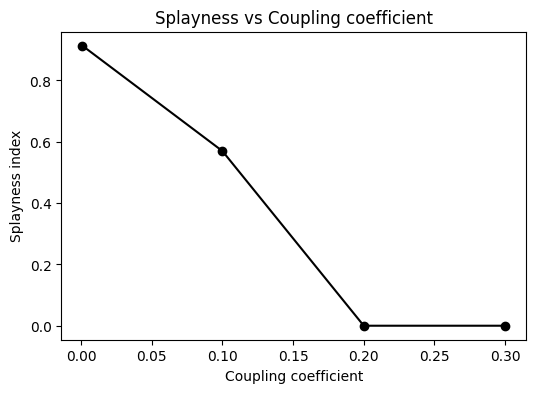

In [ ]:
# plot cc vs splayness
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cc_array, spm_array, '-o', c='k')
ax.set_xlabel('Coupling coefficient')
ax.set_ylabel('Splayness index')
ax.set_title('Splayness vs Coupling coefficient')
plt.show()



In [ ]:
tstart 

2.0738

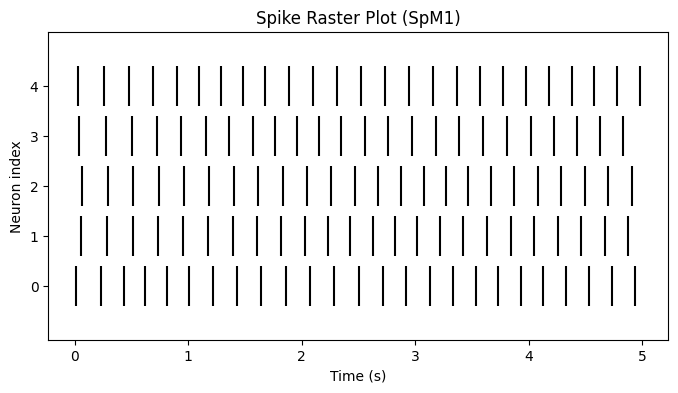

In [ ]:
# find interspike intervals for 4 neurons
N = 5
isi_list = []
for i in range(N):
    spike_times_i = SpM1.t_[SpM1.i == i] / ms  # convert to ms
    isis = np.diff(spike_times_i)  # interspike intervals
    isi_list.append(isis)

print("Interspike Intervals (ms) for each neuron:")
for i, isis in enumerate(isi_list):
    print(f"Neuron {i}: {isis}")
#!/usr/bin/env python3
import numpy as np
from brian2 import *

Interspike Intervals (ms) for each neuron:
Neuron 0: [215.2 202.5 190.7 189.6 198.2 206.4 211.6 214.3 214.9 214.7 214.3 213.1
 211.3 209.  206.4 203.5 200.5 198.2 197.3 198.3 200.2 202.5 204.4 205.5] Hz
Neuron 1: [231.7 226.6 222.4 220.7 218.8 216.8 214.8 212.2 208.1 203.4 198.8 195.4
 195.2 198.  201.8 204.9 206.9 208.  208.2 208.  207.2 206.  204.6] Hz
Neuron 2: [229.2 225.5 222.3 221.2 219.9 218.7 217.7 216.2 213.9 211.6 208.8 205.1
 201.1 197.8 196.6 197.7 200.3 203.1 205.2 206.6 207.3 207.4 206.9] Hz
Neuron 3: [232.  226.5 220.9 217.6 214.  209.3 203.5 197.2 192.9 193.8 198.6 203.4
 206.9 208.9 209.9 210.2 209.8 208.9 207.5 205.7 203.8 201.8 200.2] Hz
Neuron 4: [228.  221.6 213.5 205.2 196.8 191.5 193.5 200.1 206.1 209.9 212.  212.6
 212.1 211.4 210.4 209.  207.4 205.1 202.7 200.5 198.9 198.8 199.7 201.3] Hz
